# ***神经网络思想实现Logistic回归***

# 0. 要解决的问题

案例描述：将学习如何建立逻辑回归分类器用来识别猫。

note：  
1. 这项作业将引导你逐步了解神经网络的思维方式，同时磨练你对深度学习的直觉。
2. 除非指令中明确要求使用，否则请勿在代码中使用循环（for / while）。 

建立学习算法的一般架构，包括：
1. 初始化参数
2. 计算损失函数及其梯度
3. 使用优化算法（梯度下降）

这项作业按正确的顺序将以上所有三个功能集成到一个主模型上。

# 1. 导入包

① numpy 是Python科学计算的基本包。

② h5py是一个常用的包，可以处理存储为H5文件格式的数据集。

③ matplotlib是一个著名的Python图形库。

④ lr_utils是一个加载资料包里面的数据的简单功能的库。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import scipy.misc

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 2. 导入数据集

① 问题说明：你将获得一个包含以下内容的数据集（"data.h5"）：
1. 标记为cat（y = 1）或非cat（y = 0）的m_train训练图像集
2. 标记为cat或non-cat的m_test测试图像集
3. 图像维度为（num_px，num_px，3），其中3表示3个通道（RGB）。因此，每个图像都是正方形（高度= num_px）和（宽度= num_px）。

首先通过运行以下代码来加载数据。

note：我们在图像数据集（训练和测试）的末尾添加了"\_orig"，以便对其进行预处理。 预处理后，我们将得到train_set_x和test_set_x（标签train_set_y和test_set_y不需要任何预处理）。

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()      

② 解释一下上面的load_dataset() 返回的值的含义：

1. train_set_x_orig ：保存的是训练集里面的图像数据（本训练集有209张64x64的图像）。
2. train_set_y_orig ：保存的是训练集的图像对应的分类值（【0 | 1】，0表示不是猫，1表示是猫）。
3. test_set_x_orig ：保存的是测试集里面的图像数据（本测试集有50张64x64的图像）。
4. test_set_y_orig ： 保存的是测试集的图像对应的分类值（【0 | 1】，0表示不是猫，1表示是猫）。
5. classes ： 保存的是以bytes类型保存的两个字符串数据，数据为：[b’non-cat’ b’cat’]。

# 3. 查看图片数据

① train_set_x_orig和test_set_x_orig的每一行都是代表图像的数组。 你可以通过运行以下代码来可视化示例。 还可以随意更改index值并重新运行以查看其他图像。

y = [1], it's a 'cat' picture.


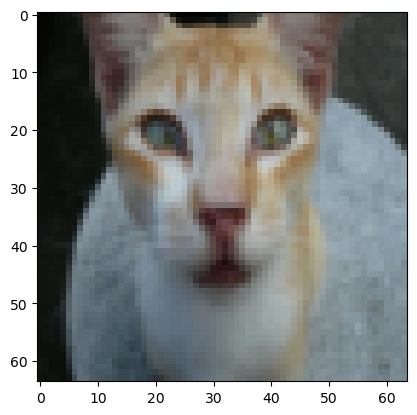

In [3]:
# Example of a picture
# 打印出当前的训练标签值
# 使用np.squeeze的目的是压缩维度，【未压缩】train_set_y[:,index]的值为[1] , 【压缩后】np.squeeze(train_set_y[:,index])的值为1
# print("【使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) + "，不使用np.squeeze： " + str(train_set_y[:,index]) + "】")
# 只有压缩后的值才能进行解码操作
index = 11
plt.imshow(train_set_x_orig[index]) 
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")                 

# 4. 查看向量尺寸

① 深度学习中的许多报错都来自于矩阵/向量尺寸不匹配。 如果你可以保持矩阵/向量的尺寸不变，那么将消除大多错误。

练习： 查找以下各项的值：
1. m_train（训练集示例数量）
2. m_test（测试集示例数量）
3. num_px（=训练图像的高度=训练图像的宽度）

note："train_set_x_orig" 是一个维度为（m_train，num_px，num_py，3）的numpy数组。 例如，你可以通过编写“ train_set_x_orig.shape [0]”来访问“ m_train”。

In [4]:
print(f"train_set_x_orig.shape: {train_set_x_orig.shape}")
m_train, num_px, num_py, channel = train_set_x_orig.shape
print(f"m_train: {m_train}")

m_test, num_px, num_py, channel = test_set_x_orig.shape
print(f"m_test: {m_test}")

print(f"num_px: {num_px}, num_py: {num_py}")

train_set_x_orig.shape: (209, 64, 64, 3)
m_train: 209
m_test: 50
num_px: 64, num_py: 64


# 5. 重塑维度

① 为了方便起见，你现在应该以维度(num_px * num_px * 3, 1)的numpy数组重塑维度（num_px，num_px，3）的图像。 

② 此后，我们的训练（和测试）数据集是一个numpy数组，其中每列代表一个展平的图像。 应该有m_train（和m_test）列。

练习： 重塑训练和测试数据集，以便将大小（num_px，num_px，3）的图像展平为单个形状的向量(num_px × num_px × 3, 1)。

③ 当你想将维度为（a，b，c，d）的矩阵X展平为形状为(b * c * d, a)的矩阵X_flatten时的一个技巧是：X_flatten = X.reshape（X.shape [0]，-1）.T     ＃ 其中X.T是X的转置矩阵

In [5]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
print(f"train_set_x_flatten.shape: {train_set_x_flatten.shape}")

test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print(f"test_set_x_flatten.shape: {test_set_x_flatten.shape}")

# 每列代表一个展平的图像，搞成这样是为了干啥啊？搞矩阵乘法放到 A @ B 的B位置？

train_set_x_flatten.shape: (12288, 209)
test_set_x_flatten.shape: (12288, 50)


① 这一段意思是指把数组变为209行的矩阵（因为训练集里有209张图片），但是我懒得算列有多少，于是我就用-1告诉程序你帮我算，最后程序算出来时12288列。

② 我再最后用一个T表示转置，这就变成了12288行，209列。

③ 测试集亦如此。

In [6]:
# 看看降维之后的情况是怎么样的
print ("训练集降维最后的维度: " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数: " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数: " + str(test_set_y.shape))

训练集降维最后的维度: (12288, 209)
训练集_标签的维数: (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数: (1, 50)


# 6.标准化数据集

① 为了表示彩色图像，必须为每个像素指定红色，绿色和蓝色通道（RGB），因此像素值实际上是从0到255范围内的三个数字的向量。

② 机器学习中一个常见的预处理步骤是对数据集进行居中和标准化，这意味着可以减去每个示例中整个numpy数组的平均值，然后将每个示例除以整个numpy数组的标准偏差。

③ 但对于图片数据集，它更简单，更方便，几乎可以将数据集的每一行除以255（像素通道的最大值），因为在RGB中不存在比255大的数据，所以我们可以放心的除以255，让标准化的数据位于[0,1]之间。

④ 现在标准化我们的数据集：

In [7]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

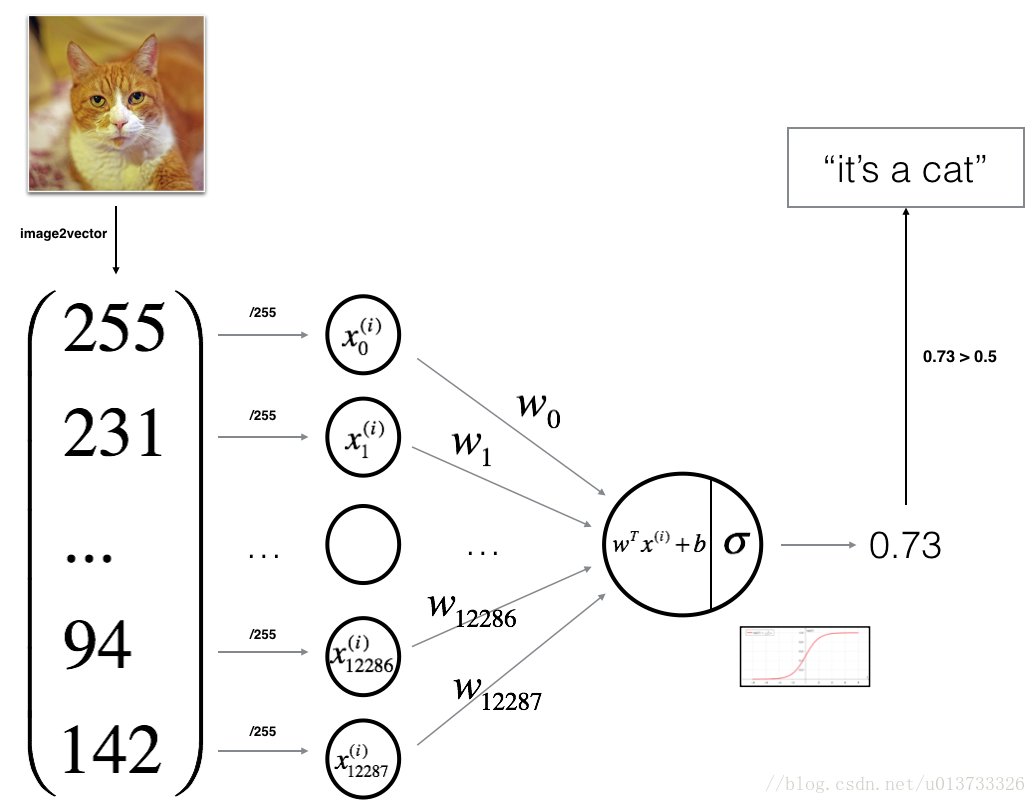

# 7. 预处理数据集

① 预处理数据集的常见步骤是：

1. 找出数据的尺寸和维度（m_train，m_test，num_px等）
2. 重塑数据集，以使每个示例都是大小为（num_px * num_px * 3，1）的向量
3. “标准化”数据

# 8. 建立神经网络

## 8.1 建立神经网络数学模型

① 现在总算是把我们加载的数据弄完了，我们现在开始构建神经网络。

② 对于 $x^{(i)}$
$z^{(i)} = w^T x^{(i)} + b \tag{1}$
$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$
$\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$ 

③ 然后通过对所有训练样例求和来计算成本：

$J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$

## 8.2 建立神经网络主要步骤

① 建立神经网络的主要步骤是：

1. 定义模型结构（例如输入特征的数量）
2. 初始化模型的参数
3. 循环：
 - 3.1 计算当前损失（正向传播）
 - 3.2 计算当前梯度（反向传播）
 - 3.3 更新参数（梯度下降）

## 8.3 建立神经网络各个部分

### 8.3.1 建立sigmoid()函数

① 计算$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$去预测，需要使用np.exp（）。

In [8]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。
    
    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s

② 测试一下sigmoid()，检查一下是否符合我们所需要的条件。

In [9]:
# 测试一下 sigmoid 函数
print("====================测试sigmoid====================")
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2))) 
print ("sigmoid([0, -9.2]) = " + str(sigmoid(np.array([0,-9.2]))))

====================测试sigmoid====================
sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922
sigmoid([0, -9.2]) = [5.00000000e-01 1.01029194e-04]


### 8.3.2 建立initialize()函数

练习：在下面的单元格中实现参数初始化。
1. 你必须将w初始化为零的向量。
2. 如果你不知道要使用什么numpy函数，请在Numpy库的文档中查找np.zeros()。

In [10]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。
        
        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）
        
        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros((dim, 1))
    b = 0
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 8.3.3 建立propagate()函数

① 初始化参数的函数已经构建好了，现在就可以执行“前向”和“后向”传播来学习参数。

② 我们现在要实现函数propagate()来计算损失函数及其梯度。

③ 正向传播：
1. 获得X
2. 计算$A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
3. 计算损失函数：$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

④ 计算梯度，你将要使用到以下两个公式：
$\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$
$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$

In [11]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的传播函数，计算成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    # X.shape = (num_px * num_px * 3, m)
    # w.T.shape = (1, num_px * num_px * 3)
    # w.T dot X shape = (1, m)
    z = np.dot(w.T, X) # shape=(1, m)
    A = sigmoid(z)

    # Y.shape = (1, m)
    _, m = Y.shape
    cost = - (1.0 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # X.shape = (num_px * num_px * 3, m)
    # A - Y shape = (1, m)
    # dw.shape = (num_px * num_px * 3, 1)
    # 完美！dw.shape 应该就是 w.shape，不然咋update w呢
    dw = (1.0 / m) * np.dot(X, (A - Y).T)

    # db是一个标量，和b一样，完美
    db = (1.0 / m) * np.sum(A - Y)

    return {"dw": dw, "db": db}, cost

In [12]:
# 测试一下 propagate 函数
print("====================测试propagate====================")
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

====================测试propagate====================
dw = [[0.99949908]
 [1.99854263]]
db = 0.4995217754684485
cost = 5.00047843267698


### 8.3.4 建立optimize()函数

① 现在，我要使用渐变下降更新参数。

② 目标是通过最小化成本函数$J$来学习$w$和$b$。

③ 对于参数$\theta$，更新规则是$ \theta = \theta - \alpha \text{ } d\theta$，其中$\alpha$是学习率。

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):    
    """
    此函数通过运行梯度下降算法来优化w和b
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值
    
    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。
    
    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """

    costs = list()
    for iter_id in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        w = w - learning_rate * grads["dw"]
        b = b - learning_rate * grads["db"]

        costs.append(cost)
        if print_cost and (iter_id + 1) % 100 == 0:
            print(f"iter: {iter_id + 1}, cost: {cost}")
            

    return {"w": w, "b": b}, {"dw": grads["dw"], "db": grads["db"]}, np.array(costs)
    

In [14]:
#测试一下 optimize 函数
print("====================测试optimize====================")
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = True)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print(costs)

====================测试optimize====================
iter: 100, cost: 1.0418893773791553
w = [[0.14714641]
 [0.31844247]]
b = 1.5856480307124026
dw = [[0.71513716]
 [1.3095054 ]]
db = 0.2971841174463113
[5.00047843 4.95554091 4.91060756 4.86567867 4.82075454 4.77583549
 4.73092187 4.68601403 4.64111238 4.59621734 4.55132934 4.50644888
 4.46157645 4.41671262 4.37185796 4.3270131  4.2821787  4.23735548
 4.19254421 4.14774569 4.10296081 4.05819048 4.01343572 3.96869758
 3.9239772  3.87927581 3.8345947  3.78993526 3.74529898 3.70068746
 3.65610239 3.6115456  3.56701901 3.52252472 3.47806493 3.43364203
 3.38925854 3.34491718 3.30062083 3.25637259 3.21217575 3.16803385
 3.12395064 3.07993014 3.03597663 2.99209469 2.94828919 2.90456533
 2.86092865 2.81738506 2.77394083 2.73060265 2.68737765 2.64427339
 2.60129791 2.55845975 2.51576797 2.47323217 2.43086254 2.38866984
 2.34666547 2.30486146 2.2632705  2.22190597 2.18078194 2.13991321
 2.09931529 2.05900443 2.01899762 1.97931258 1.93996777 1.9009

### 8.3.5 建立predict()函数

① optimize函数会输出已学习的w和b的值，我们可以使用w和b来预测数据集X的标签。

② 现在我们要实现预测函数predict（）。计算预测有两个步骤：
1. 计算$\hat{Y} = A = \sigma(w^T X + b)$
2. 将a的项转换为0（如果激活<= 0.5）或1（如果激活> 0.5），并将预测结果存储在向量“ Y_prediction”中。

In [15]:
def predict(w, b, X):  
    """
    使用学习逻辑回归参数 logistic(w，b) 预测标签是0还是1，
    
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据
    
    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）
    
    """
    
    # Y_hat.shape = (1, m)
    Y_hat = sigmoid(np.dot(w.T, X) + b)

    Y_prediction = np.where(Y_hat > 0.5, 1, 0)
    
    return Y_prediction

In [16]:
# 测试一下 predict 函数
print("====================测试predict====================")
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
print("predictions = " + str(predict(w, b, X)))

====================测试predict====================
predictions = [[1 1]]


# 9. 功能合并模型中

## 9.1 搭建模型

① 就目前而言，我们基本上把所有的东西都做完了，现在我们要把这些函数统统整合到一个model()函数中，届时只需要调用一个model()就基本上完成所有的事了。

② 将所有构件（在上一部分中实现的功能）以正确的顺序放在一起，从而得到整体的模型结构。

In [17]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):    
    """
    通过调用之前实现的函数来构建逻辑回归模型
    
    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本
    
    返回：
        d  - 包含有关模型信息的字典。
    """
    
    dim, m_train = X_train.shape
    w, b = initialize_with_zeros(dim)

    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w, b = params["w"], params["b"]
    
    Y_train_prediction = predict(w, b, X_train)
    train_acc = np.sum(np.where(Y_train_prediction == Y_train, 1, 0)) / m_train

    dim, m_test = X_test.shape
    Y_test_prediction = predict(w,b, X_test)
    test_acc = np.sum(np.where(Y_test_prediction == Y_test, 1, 0)) / m_test

    print(f"train_acc: {train_acc}")
    print(f"test_acc: {test_acc}")
    
    d = {"costs": costs, "Y_prediction_test": Y_test_prediction, "learning_rate": learning_rate, "train_acc": train_acc, "test_acc": test_acc}
    
    return d

## 9.2 训练模型

① 把整个model构建好之后我们这就算是正式的实际测试了，我们这就来实际跑一下。

In [18]:
print("====================测试model====================")
# 这里加载的是真实的数据
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)             

====================测试model====================
iter: 100, cost: 0.644331217956321
iter: 200, cost: 0.4844293481983564
iter: 300, cost: 0.37753004221596054
iter: 400, cost: 0.3318121443875839
iter: 500, cost: 0.3035538268301409
iter: 600, cost: 0.28011013126151507
iter: 700, cost: 0.2602345510641274
iter: 800, cost: 0.24310350774340472
iter: 900, cost: 0.22814367987470316
iter: 1000, cost: 0.21494025104233458
iter: 1100, cost: 0.2031837389141283
iter: 1200, cost: 0.1926373608853933
iter: 1300, cost: 0.18311608579968025
iter: 1400, cost: 0.17447268813805178
iter: 1500, cost: 0.16658817883231608
iter: 1600, cost: 0.15936506909378434
iter: 1700, cost: 0.1527225228775725
iter: 1800, cost: 0.14659280028140967
iter: 1900, cost: 0.14091860252750907
iter: 2000, cost: 0.1356510585969811
train_acc: 0.9904306220095693
test_acc: 0.7


② 训练准确性接近100％。这是一个很好的情况。

③ 测试误差为70％。考虑到我们使用的数据集很小，并且逻辑回归是线性分类器，对于这个简单的模型来说，这实际上还不错。下周你将建立一个更好的分类器！

④ 我们更改一下学习率和迭代次数，有可能会发现训练集的准确性可能会提高，但是测试集准确性会下降，这是由于过拟合造成的，但是我们并不需要担心，我们以后会使用更好的算法来解决这些问题的。

## 9.3 预测模型

① 使用下面的代码（并更改index变量），你可以查看测试集图片上的预测。

y = 1, you predicted that it is a "cat" picture.


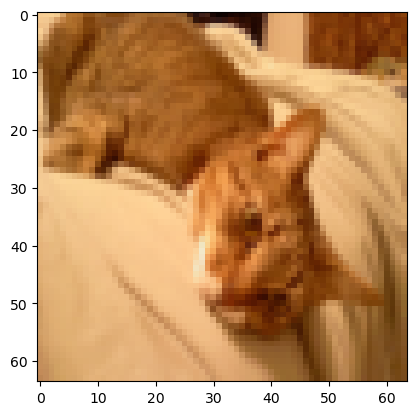

In [19]:
index = 26
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

## 9.4 绘制损失

① 到目前为止，我们的程序算是完成了，但是，我们可以在后面加一点东西，比如画点图什么的。

② 跑一波出来的效果图是这样的，可以看到损失下降，它显示参数正在被学习。

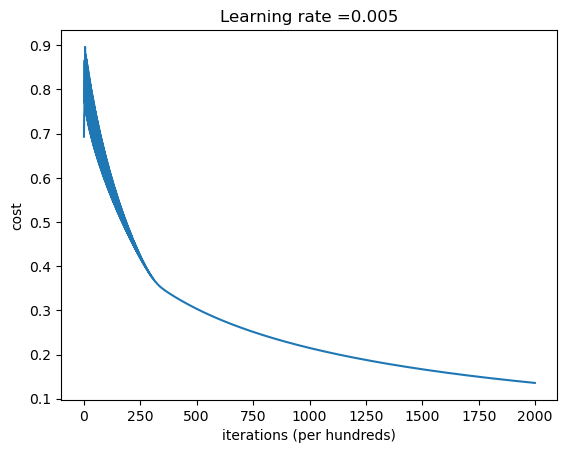

In [20]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## 9.5 迭代次数的选择

① 尝试增加上面单元格中的迭代次数，然后重新运行这些单元格。你可能会看到训练集准确性提高了，但是测试集准确性却降低了。这称为过度拟合。

② 我们以后会使用更好的算法来解决过拟合问题的。

## 9.6 学习率的选择

① 让我们进一步分析一下，并研究学习率的可能选择。

② 为了让渐变下降起作用，我们必须明智地选择学习速率。

③ 学习率 $\alpha$ 决定了我们更新参数的速度。
1. 如果学习率过高，我们可能会“超过”最优值。
2. 如果它太小，我们将需要太多迭代才能收敛到最佳值。

④ 这就是为什么使用良好调整的学习率至关重要的原因。

⑤ 我们可以比较一下我们模型的学习曲线和几种学习速率的选择。也可以尝试使用不同于我们初始化的learning_rates变量包含的三个值，并看一下会发生什么。

⑥ 解释：

1. 不同的学习率会带来不同的损失，因此会有不同的预测结果。
2. 如果学习率太大（0.01），则成本可能会上下波动。 它甚至可能会发散（尽管在此示例中，使用0.01最终仍会以较高的损失值获得收益）。
3. 较低的损失并不意味着模型效果很好。当训练精度比测试精度高很多时，就会发生过拟合情况。
4. 在深度学习中，我们通常建议你：
 - 选择好能最小化损失函数的学习率。
 - 如果模型过度拟合，请使用其他方法来减少过度拟合。 （我们将在后面的教程中讨论。）

learning rate is: 0.01
train_acc: 0.9952153110047847
test_acc: 0.68

-------------------------------------------------------

learning rate is: 0.001
train_acc: 0.8851674641148325
test_acc: 0.64

-------------------------------------------------------

learning rate is: 0.0001
train_acc: 0.6842105263157895
test_acc: 0.36

-------------------------------------------------------



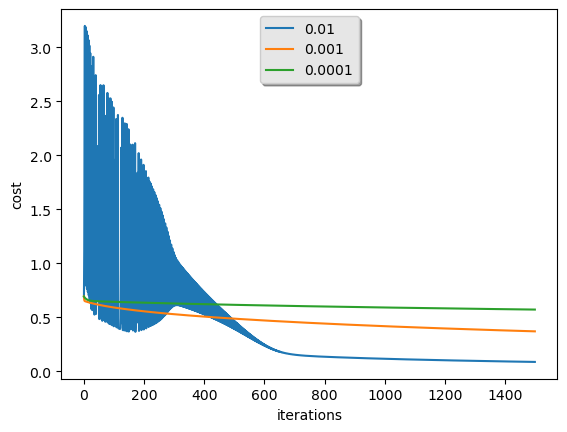

In [21]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()